
# 4.2: Record and plot extracellular potentials

The main output of HNN simulations is the 'dipole' waveform, i.e., the net
intracellular current flowing in pyramidal cell apical dendrites. At the large
distances between cells and M/EEG sensors, this 'primary' current is the main
contributor to the measured fields. Close to the cells, the local field
potential (LFP) is the result of intracellular current leaking into the
extracellular medium through active and passive membrane channels. Under some
simplifying assumptions, we may approximate the LFP at virtual electrodes
placed in and around the HNN network model.


In [1]:
# Authors: Christopher Bailey <cjb@cfin.au.dk>
#          Mainak Jas <mainakjas@gmail.com>
#          Nick Tolley <nicholas_tolley@brown.edu>

import matplotlib.pyplot as plt

from hnn_core import jones_2009_model, simulate_dipole
from hnn_core.network_models import add_erp_drives_to_jones_model

--No graphics will be displayed.


The default network model defined in (Jones et al. 2009) consists of a
square grid of pyramidal cells. The in-plane distance between pyramidal cell
somas on the grid can be set by the user, which will have an influence on the
extracellular potentials (but not on the calculated net intracellular dipole
moment). In this example, we'll simulate a network of model cells spaced
30 um apart. To drive the network dynamics, we'll use three evoked 'ERP'
drives; see the event-related potential (ERP) example for details.

In [2]:
net = jones_2009_model()
add_erp_drives_to_jones_model(net)

net.set_cell_positions(inplane_distance=30.)

Extracellular recordings require specifying the electrode positions. It can be
useful to visualize the cells of the network to decide on the placement of
each electrode.



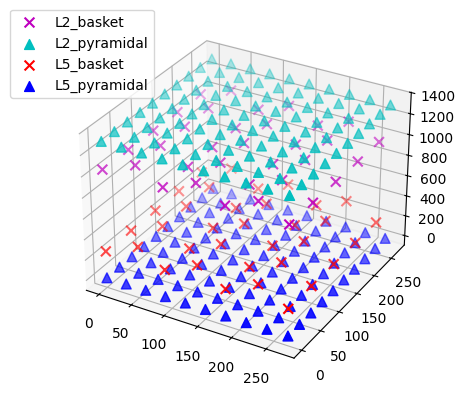

In [3]:
net.plot_cells(show=False)
plt.show()

The default network consists of 2 layers (L2 and L5), within which the cell
somas are arranged in a regular grid, and apical dendrites are aligned along
the z-axis. We can simulate a linear multielectrode array with 100 um
intercontact spacing (Kajikawa and Schroeder 2011) by specifying a list of (x, y, z) coordinate
triplets. The L5 pyramidal cell somas are at z=0 um, with apical dendrites
extending up to z~2000 um. L2 pyramidal cell somas reside at
z~1300 um, and have apical dendrites extending to z~2300 um. We'll place the
recording array in the center of the network. By default, a value of
0.3 S/m is used for the constant extracellular conductivity and the
'point source approximation' for calculations; see 
[hnn_core.Network.add_electrode_array](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.Network.html#hnn_core.Network.add_electrode_array)
for details.

In [4]:
depths = list(range(-325, 2150, 100))
electrode_pos = [(135, 135, dep) for dep in depths]
net.add_electrode_array('shank1', electrode_pos)

The electrode arrays are stored under `Network.rec_arrays` as a dictionary of 
[hnn_core.extracellular.ExtracellularArray](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.extracellular.ExtracellularArray.html#hnn_core.extracellular.ExtracellularArray)
objects that are now attached to the network and will be recorded during the simulation. Note that
calculating the extracellular potentials requires additional computational
resources and will thus slightly slow down the simulation.
[Using MPI](https://jonescompneurolab.github.io/textbook/content/09_feature_demos/use_mpi_backend_for_parallelization.html)
will speed up computation considerably.

{'shank1': <ExtracellularArray | 25 electrodes, conductivity=0.3, method=psa (no data recorded yet)>}


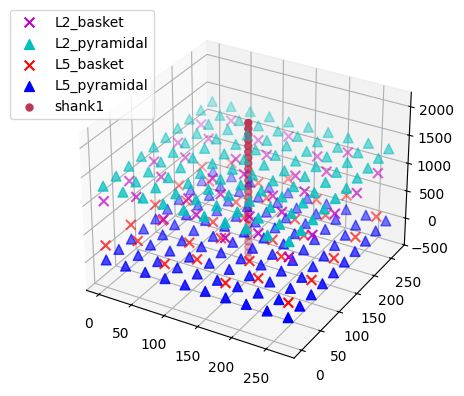

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


In [5]:
print(net.rec_arrays)
net.plot_cells(show=False)
plt.show()

dpl = simulate_dipole(net, tstop=170)

For plotting both aggregate dipole moment and LFP traces, we'll use a 10 ms
smoothing window, after which both data can be decimated by a factor of 20
from 40 to 2 kHz sampling rates (note that decimation is applied in two
steps). Decimation speeds up plotting significantly.



In [6]:
trial_idx = 0
window_len = 10  # ms
decimate = [5, 4]  # from 40k to 8k to 2k

# Then plot the aggregate dipole time series on its own axis
dpl[trial_idx].smooth(window_len=window_len)

# Use the same smoothing window on the LFP traces to allow comparison to dipole
electrode_data = net.rec_arrays['shank1'][trial_idx].smooth(window_len=window_len)

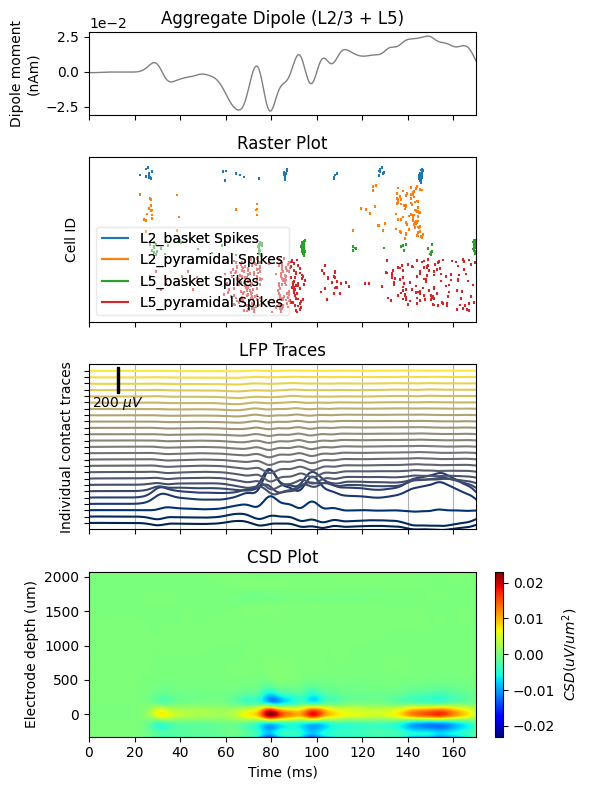

In [7]:
fig, axs = plt.subplots(4, 1, 
                        sharex=True, 
                        figsize=(6, 8),
                        gridspec_kw={'height_ratios': [1, 2, 2, 2]})

dpl[trial_idx].plot(ax=axs[0], decim=decimate, show=False)
axs[0].set_xlabel('')
axs[0].set_ylabel('Dipole moment\n(nAm)')
axs[0].set_title('Aggregate Dipole (L2/3 + L5)')

# Add spike raster to subplot
net.cell_response.plot_spikes_raster(ax=axs[1], show=False)
axs[1].set_xlabel('')
axs[1].set_title('Raster Plot')

# Add smoothed LFP traces to next subplot
electrode_data.plot_lfp(ax=axs[2], decim=decimate, show=False)
axs[2].grid(True, which='major', axis='x')
axs[2].set_xlabel('')
axs[2].set_yticklabels('')
axs[2].set_title('LFP Traces')

# Finally, add the CSD to the bottom subplot
electrode_data.plot_csd(ax=axs[3], show=False)
axs[3].set_xlabel('Time (ms)')
axs[3].set_ylabel('Electrode depth (um)')
axs[3].set_title('CSD Plot')
plt.tight_layout()
plt.show()

## References

-  Jones, Stephanie R., Dominique L. Pritchett, Michael A. Sikora, Steven M. Stufflebeam, Matti Hämäläinen, and Christopher I. Moore. 2009. “Quantitative Analysis and Biophysically Realistic Neural Modeling of the MEG Mu Rhythm: Rhythmogenesis and Modulation of Sensory-Evoked Responses.” Journal of Neurophysiology 102 (6): 3554–72. [https://doi.org/10.1152/jn.00535.2009](https://doi.org/10.1152/jn.00535.2009). 

- Kajikawa, Yoshinao, and Charles E. Schroeder. 2011. “How Local Is the Local Field Potential?” Neuron 72 (5): 847–58. [https://doi.org/10.1016/j.neuron.2011.09.029](https://doi.org/10.1016/j.neuron.2011.09.029).